## Basic Imports

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import sys

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import make_pipeline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

import matplotlib.pyplot as plt
%matplotlib inline

## Loading Data

**Note:** looks like the training set has 40,000 data-points and the test set has 10,000 data-points

In [3]:
DATA_PATH = os.path.join("../data/")

def load_churn_data(path=DATA_PATH, train=True):
    if train:
        csv_path = os.path.join(path, "churn_train.csv")
    else:
        csv_path = os.path.join(path, "churn_test.csv")
    return pd.read_csv(csv_path)

In [4]:
#load train data
churn_train_orig = load_churn_data(path=DATA_PATH, train=True)
churn_train = churn_train_orig.copy()

#load test data
churn_test_orig = load_churn_data(path=DATA_PATH, train=False)
churn_test = churn_test_orig.copy()

In [5]:
churn_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 12 columns):
avg_dist                  40000 non-null float64
avg_rating_by_driver      39838 non-null float64
avg_rating_of_driver      33472 non-null float64
avg_surge                 40000 non-null float64
city                      40000 non-null object
last_trip_date            40000 non-null object
phone                     39681 non-null object
signup_date               40000 non-null object
surge_pct                 40000 non-null float64
trips_in_first_30_days    40000 non-null int64
luxury_car_user           40000 non-null bool
weekday_pct               40000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 3.4+ MB


In [6]:
churn_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
avg_dist                  10000 non-null float64
avg_rating_by_driver      9961 non-null float64
avg_rating_of_driver      8406 non-null float64
avg_surge                 10000 non-null float64
city                      10000 non-null object
last_trip_date            10000 non-null object
phone                     9923 non-null object
signup_date               10000 non-null object
surge_pct                 10000 non-null float64
trips_in_first_30_days    10000 non-null int64
luxury_car_user           10000 non-null bool
weekday_pct               10000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 869.2+ KB


## Pipline Custom Transfomer Classes

In [7]:
boolean_attributes     = ['luxury_car_user']

datetime_attributes    = ["last_trip_date", "signup_date"]

categorical_attributes = ["city", "phone"]

numerical_attributes   = ["avg_dist", 
                          "avg_rating_by_driver", 
                          "avg_rating_of_driver", 
                          "avg_surge", 
                          "surge_pct", 
                          "trips_in_first_30_days", 
                          "weekday_pct"]


numerical_indices = churn_train.drop(datetime_attributes + categorical_attributes + boolean_attributes, axis=1).columns
bool_indices = churn_train.drop(datetime_attributes + categorical_attributes + numerical_attributes, axis=1).columns

### Dataframe Selector Class
this class will take in a dataframe X and return only the selected attributes of X

In [8]:
class dataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, selected_attributes):
        self.selected_attributes = selected_attributes
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        #assert isinstance(X, pd.DataFrame)
        return X[self.selected_attributes]

### Feature Engineering Class
this class will take in a dataframe X and and return X after selectively adding in newly engineered features

In [9]:
class featureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self, add_weak_user=True, add_power_user=True, add_extreme_dist=True):
        self.add_power_user = add_power_user
        self.add_weak_user = add_weak_user
        self.add_extreme_dist = add_extreme_dist

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        #assert isinstance(X, pd.DataFrame)
        if self.add_weak_user:
            weak_user = (X.loc[:, 'trips_in_first_30_days'] <= 2).astype(int)
            X = pd.concat([X, weak_user.rename('weak_user')], axis=1)
            
        if self.add_power_user:
            power_user = (X.loc[:, 'trips_in_first_30_days'] >= 5).astype(int)
            X = pd.concat([X, power_user.rename('power_user')], axis=1)
            
        if self.add_extreme_dist:
            bins = [0,1.8,10,100]
            avg_distance_split = pd.cut(X['avg_dist'], bins=bins, labels=False)
            X['extreme_dist'] = (avg_distance_split != 1).astype(int)
        
        return X

### Imputer Converter Class
this class  will take in a dataframe X and return X with imputed values to missing data points 

In [10]:
class imputerConverter(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_indices):
        self.attribute_indices = attribute_indices

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        #assert isinstance(X, pd.DataFrame)
        imputer = Imputer(strategy='median')
        imputer.fit(X)
        X = imputer.transform(X)
        return pd.DataFrame(X, columns=self.attribute_indices)

### Type Converter Class
this class will take in a dataframe and return a dataframe after converting tye types of certain columns

In [11]:
class typeConverter(BaseEstimator, TransformerMixin):
    def __init__(self, convert_to_int=True, convert_to_datetime=False):
        self.convert_to_int = convert_to_int
        self.convert_to_datetime = convert_to_datetime
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        #assert isinstance(X, pd.DataFrame)
        if self.convert_to_int:
            return X[:].astype(int)
        elif self.convert_to_datetime:
            return X.iloc[:, :].apply(pd.to_datetime, errors='coerce')
        else:
            return X

### Output Adder Class
this class will take in a dataframe and return the dataframe after adding the target output column

In [12]:
class outputAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        #assert isinstance(X, pd.DataFrame)
        end_date = pd.to_datetime('2014-07-01')
        delta = pd.Timedelta('30 days')
        
        X['churn'] = ((end_date - X['last_trip_date']) >= delta).astype(int)
        return X

### Get Dummies Class
this class will take in a dataframe and return a dummified dataframe of all categorical features

In [13]:
class getDummies(BaseEstimator, TransformerMixin):
    def __init__(self, dummy_cols = []):
        self.dummy_cols = dummy_cols
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        #assert isinstance(X, pd.DataFrame)
        return pd.get_dummies(data=X, columns=self.dummy_cols, drop_first=True)

### Feature Dropper Class
this class will take in a dataframe and return the dataframe after dropping a few selected features

In [14]:
class featureDropper(BaseEstimator, TransformerMixin):
    def __init__(self, drop_list = []):
        self.drop_list = drop_list
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        #assert isinstance(X, pd.DataFrame)
        X.drop(self.drop_list, axis=1, inplace=True)
        return X

## Building Final Pipeline

In [15]:
datetime_pipe = Pipeline([
                            ('selector', dataFrameSelector(datetime_attributes)),
                            ('type converter', typeConverter(convert_to_int=False, convert_to_datetime=True)),
                            ('feature dropper', featureDropper(datetime_attributes))
                        ])

In [16]:
numerical_pipe = Pipeline([
                            ('selector', dataFrameSelector(numerical_attributes)),
                            ('imputor', imputerConverter(numerical_indices)),
                            ('feature engineer', featureEngineering()),
                            ('scale', StandardScaler())
                         ])

In [17]:
bool_pipe = Pipeline([
                        ('selector', dataFrameSelector(boolean_attributes)),
                        ('imputor', imputerConverter(bool_indices)),
                        ('type converter', typeConverter(convert_to_int=True, convert_to_datetime=False))
                    ])

In [18]:
categorical_pipe = Pipeline([
                                ('selector', dataFrameSelector(categorical_attributes)),
                                ('dummify', getDummies(categorical_attributes))
                            ])

In [19]:
pre_process_pipe = FeatureUnion(transformer_list=[
                            ('num pipe', numerical_pipe),
                            ('bool pipe', bool_pipe),
                            ('date pipe', datetime_pipe),
                            ('cat pipe', categorical_pipe)
                        ])

In [20]:
churn_train_X = pre_process_pipe.fit_transform(churn_train)
churn_test_X = pre_process_pipe.fit_transform(churn_test)
print(churn_train_X.shape)
print(churn_test_X.shape)

(40000, 14)
(10000, 14)


## Generating Targets for Test/Train

In [21]:
def createOutput(data_frame, output_col_name, return_type_numpy=True):
    end_date = pd.to_datetime('2014-07-01')
    delta = pd.Timedelta('30 days')
    
    data_frame['signup_date'] = pd.to_datetime(data_frame['signup_date'])
    data_frame['last_trip_date'] = pd.to_datetime(data_frame['last_trip_date'])
    data_frame[output_col_name] = ((end_date - data_frame['last_trip_date']) >= delta).astype(int)
    
    if return_type_numpy:
        return data_frame[output_col_name].values
    else:
        return data_frame[output_col_name]

In [22]:
churn_train_y = createOutput(churn_train, 'churn', return_type_numpy=True)
churn_test_y = createOutput(churn_test, 'churn', return_type_numpy=True)
print(churn_train_y.shape, churn_test_y.shape)


(40000,) (10000,)


## Scoring Class

In [49]:
class modelScorer():
    def __init__(self, title, model, y, X):
        """
        title --> string --> describe the model (used for book keeping)
        model --> sklearn model
        y     --> np array --> target output column from feature matrix 
        X     --> np array --> feature matrix
        """
        self.title = title
        self.model = model
        self.y = y
        self.X = X
        
        self.y_predict = self.model.predict(self.X)
        
        self.confusion_matrx = confusion_matrix(self.y, self.y_predict)
        self.accuracy_scr = accuracy_score(self.y, self.y_predict)
        self.recall_scr = recall_score(self.y, self.y_predict)
        self.precision_scr = precision_score(self.y, self.y_predict)
        
    def genScoreReport(self):
        print("\t\tSCORE FOR {}".format(self.title))
        print("Accuracy:{0:.2f}".format(self.accuracy_scr))
        print("Recall:{0:.2f}".format(self.recall_scr))
        print("Precision:{0:.2f}".format(self.precision_scr))
        print("\nConfusion Matrix:\n {}".format(self.confusion_matrx))
        
    def plot_roc(self):
        AUC = roc_auc_score(self.y, self.model.predict_proba(self.X)[:,1])
        fpr, tpr, thresholds = roc_curve(self.y, self.model.predict_proba(self.X)[:,1])
    
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % AUC)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic:: {}'.format(self.title))
        plt.legend(loc="lower right");
        
    def getAccuracyScore(self):
        return self.accuracy_scr
    
    def getRecallScore(self):
        return self.recall_scr
    
    def getPrecisionScore(self):
        return self.precision_scr
    
    def getConfusionMatrix(self):
        return self.confusion_matrx



## Logistic Regression 

In [24]:
param_grid = {'C':[0.9]}
logistic_clf = LogisticRegression(random_state=42, class_weight='balanced')
logistic_model = GridSearchCV(logistic_clf, param_grid, cv=10)

logistic_model.fit(churn_train_X, churn_train_y);

In [25]:
logistic_test_score = modelScorer("Logistic --> Test", logistic_model, churn_test_y, churn_test_X)
logistic_train_score = modelScorer("Logistic --> Train", logistic_model, churn_train_y, churn_train_X)

In [26]:
logistic_test_score.genScoreReport()

		SCORE FOR Logistic --> Test
Accuracy:0.71
Recall:0.73
Precision:0.80

Confusion Matrix:
 [[2500 1175]
 [1737 4588]]


In [27]:
logistic_train_score.genScoreReport()

		SCORE FOR Logistic --> Train
Accuracy:0.72
Recall:0.74
Precision:0.80

Confusion Matrix:
 [[10015  4620]
 [ 6612 18753]]


## Random Forest

In [28]:
param_grid = {   
                'max_features': [2]
             }

rf_clf = RandomForestClassifier(
                                    random_state=42,
                                    n_jobs=-1,
                                    class_weight='balanced',
                                    min_samples_leaf=2,
                                    bootstrap=True,
                                    min_samples_split=10,
                                    max_depth = 20,
                                    n_estimators = 1000
                                )

rf_model = GridSearchCV(rf_clf, param_grid, cv=10)
rf_model.fit(churn_train_X, churn_train_y);

In [29]:
rf_test_score = modelScorer("Random Forest --> Test", rf_model, churn_test_y, churn_test_X)
rf_train_score = modelScorer("Random Forest --> Train", rf_model, churn_train_y, churn_train_X)

In [30]:
rf_test_score.genScoreReport()

		SCORE FOR Random Forest --> Test
Accuracy:0.78
Recall:0.82
Precision:0.83

Confusion Matrix:
 [[2618 1057]
 [1162 5163]]


In [31]:
rf_train_score.genScoreReport()

		SCORE FOR Random Forest --> Train
Accuracy:0.88
Recall:0.89
Precision:0.92

Confusion Matrix:
 [[12587  2048]
 [ 2846 22519]]


## Gradient Boost

In [32]:
param_grid = {   
                'n_estimators': [1000],
                'learning_rate': [0.2],
                'max_depth': [3]
             }

gb_clf = GradientBoostingClassifier(
                                        random_state=42
                                   )

gb_model = GridSearchCV(gb_clf, param_grid, cv=10)
gb_model.fit(churn_train_X, churn_train_y);

In [33]:
gb_model.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}

In [45]:
gb_test_score = modelScorer("Gradient Boost --> Test", gb_model, churn_test_y, churn_test_X)
gb_train_score = modelScorer("Gradient Boost --> Train", gb_model, churn_train_y, churn_train_X)

In [46]:
gb_test_score.genScoreReport()

		SCORE FOR Gradient Boost --> Test
Accuracy:0.78
Recall:0.84
Precision:0.82

Confusion Matrix:
 [[2523 1152]
 [1023 5302]]


In [47]:
gb_train_score.genScoreReport()

		SCORE FOR Gradient Boost --> Train
Accuracy:0.82
Recall:0.89
Precision:0.83

Confusion Matrix:
 [[10158  4477]
 [ 2757 22608]]


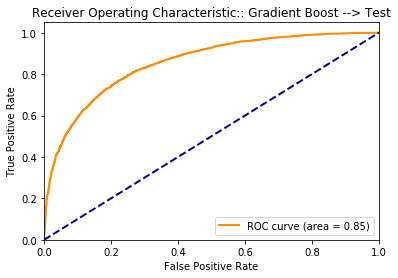

In [48]:
gb_test_score.plot_roc()